# Import packages

In [1]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test

# internal package
import OncoMarkAI as oma

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Plot setting

In [2]:
oma.pl.fig_setting()
cmap = oma.pl.cmap()
# sns.set_palette("deep");
sns.set_style("ticks");
sns.despine(offset=10, trim=True);

2023-07-19 15:15:10|INFO|plotting|Figure setting updated


<Figure size 1200x900 with 0 Axes>

In [3]:
patient_data_TCGA = oma.data.load_tcga(file_path="../OncoMarkAI/data/datasets/TCGA_log2TPMplus1_protein_coding_transcripts_20221113.h5ad", 
                                       metadata="../OncoMarkAI/data/datasets/combined_study_clinical_data_cBioPortal.tsv",
                                       filter_samples=100,
                                       sample_type="Tumor",
                                       genes=["IGSF8", "HLA-A", "HLA-B", "HLA-C", 'B2M', 'TAP1', 'TAP2'])

2023-07-19 15:15:11|INFO|dataloader|Dropping duplicates...
2023-07-19 15:15:11|INFO|dataloader|912 patient samples are missing in the RNAseq data.
2023-07-19 15:15:11|INFO|dataloader|Take Tumor samples only.
2023-07-19 15:15:11|INFO|dataloader|Take gene expression data of ['IGSF8', 'HLA-A', 'HLA-B', 'HLA-C', 'B2M', 'TAP1', 'TAP2']
2023-07-19 15:15:11|INFO|dataloader|Filtering out patients with < 100 samples...


In [4]:
# generate a dataframe to integrate expression data and metadata
expr_data = patient_data_TCGA.to_df().join(patient_data_TCGA.obs[["project_id", "samples.sample_type", "submitter_id", "cbioportal.subtype", "subtype(MSI)", "subtype(BRCA)", "subtype(SKCM)"]])
# calculate MHCI score
expr_data["MHCI"] = expr_data[["HLA-A", "HLA-B", "HLA-C", 'B2M', 'TAP1', 'TAP2']].mean(axis=1)
# there are a few duplicated samples, likely processed by different analysts, we drop the duplicates and keep only the first entries
expr_data = expr_data[~expr_data["submitter_id"].duplicated()]

In [5]:
# read the clinical data of TCGA patient samples. Data was obtained from Liu et al, Cell (2018).
CDR = pd.read_excel("../OncoMarkAI/data/datasets/TCGA-CDR_Liu2018.xlsx", index_col=1)

# remove several cohorts
# CDR = CDR[~CDR['type'].isin(["THYM", "LAML", "DLBC", "LGG"])]

# annotate the stage according to the Liu et al, Cell (2018)
CDR.loc[CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'stage'] = CDR.loc[CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'clinical_stage']
CDR.loc[~CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'stage'] = CDR.loc[~CDR['type'].isin(["CESC", "DLBC", "OV", "UCEC", "UCS"]), 'ajcc_pathologic_tumor_stage']

In [6]:
# Map the stage info into "early-stage" (1) and "late-stage" (2)
# We can also map it into 1, 2, 3, 4 as it is. The results are generally comparable, but some cohorts with few stage 4 tumors would run into issues.
mapper = {
    "Stage I": 1, "Stage IA": 1, "Stage IA1": 1, "Stage IA2": 1, "Stage IB": 1, "Stage IB1": 1, "Stage IB2": 1, "Stage IC": 1, "I/II NOS": 1,
    "Stage II": 1, "Stage IIA": 1, "Stage IIA1": 1, "Stage IIA2": 1, "Stage IIB": 1, "Stage IIC": 1,
    "Stage III": 2, "Stage IIIA": 2, "Stage IIIB": 2, "Stage IIIC": 2, "Stage IIIC1": 2, "Stage IIIC2": 2,
    "Stage IV": 2, "Stage IVA": 2, "Stage IVB": 2, "Stage IVC": 2
}

In [7]:
# Map the clinical info into expression data
expr_data["age"] = expr_data["submitter_id"].map(CDR["age_at_initial_pathologic_diagnosis"])
expr_data["gender"] = expr_data["submitter_id"].map(CDR["gender"])
expr_data["race"] = expr_data["submitter_id"].map(CDR["race"])
expr_data["stage"] = expr_data["submitter_id"].map(CDR["stage"].map(mapper))
expr_data["OS"] = expr_data["submitter_id"].map(CDR["OS"])
expr_data["OS.time"] = expr_data["submitter_id"].map(CDR["OS.time"])
expr_data["PFI"] = expr_data["submitter_id"].map(CDR["PFI"])
expr_data["PFI.time"] = expr_data["submitter_id"].map(CDR["PFI.time"])

In [8]:
def divide_samples(df_input, divideby='MHCI', cutoff='mean'):
    """
    divide TCGA samples by the `divideby` parameter according the parameter of `cutoff`
    """
    df = df_input.copy()
    if cutoff=="mean":
        df[f'{divideby}_group'] = np.sign(df[divideby] - df[divideby].mean())
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==1, "high")
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==-1, "low")

    elif cutoff=="median":
        df[f'{divideby}_group'] = np.sign(df[divideby] - df[divideby].median())
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==1, "high")
        df[f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[f'{divideby}_group'] ==-1, "low")

    elif float(cutoff) < 1 and float(cutoff) >= 0.5:     

        cutoff1 = df[divideby].quantile(q=float(cutoff))
        cutoff2 = df[divideby].quantile(q=1-float(cutoff))

        df.loc[:, f'{divideby}_group'] = "intermediate"
        df.loc[:, f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[divideby]>cutoff1, "high").copy()
        df.loc[:, f'{divideby}_group'] = df[f'{divideby}_group'].mask(df[divideby]<cutoff2, "low").copy()

    high = df[df[f'{divideby}_group'] == "high"]
    low = df[df[f'{divideby}_group'] == "low"]
    
    return high, low, df

In [9]:
def get_four_subpopulations(input_df, divideby=["MHCI", "IGSF8"], cutoff=["mean", ".75"]):
    """
    A helper function to divide patient samples into four subgroups
    """
    survival_subdata = input_df[input_df["OS.time"].notna()]
    div1_high, div1_low, _ = divide_samples(survival_subdata, divideby=divideby[0], cutoff=cutoff[0])
    
    div1_high_div2_high, div1_high_div2_low, _ = divide_samples(div1_high, divideby=divideby[1], cutoff=cutoff[1])
    div1_low_div2_high, div1_low_div2_low, _ = divide_samples(div1_low, divideby=divideby[1], cutoff=cutoff[1])
    
    return div1_high_div2_high, div1_high_div2_low, div1_low_div2_high, div1_low_div2_low

In [10]:
def logrank_p_value(data1, data2, event="OS", time="OS.time"):
    """
    calculate log rank p values
    """
    result = logrank_test(data1[time], data2[time],
                          data1[event], data2[event])
    return result.p_value

def cox_regression_p_value(survival_data, formula='age + gender + stage + IGSF8', event="OS", time="OS.time"): #   + cbioportal.subtype
    """
    Fit a cox regression model. Age, gender and stage are considered as covariates.
    """
    cph = CoxPHFitter()
    cols = formula.split(" + ") + [time, event]
    tmp = survival_data[cols].dropna()
    cph.fit(tmp, formula=formula, duration_col=time, event_col=event, robust=True)
    
    return cph.summary.loc["IGSF8", "p"], cph

In [11]:
def survival_plot(data, c=cmap.npg_palette(3),label='IGSF8 high (top 25%)', event="OS", time="OS.time", ax=None):
    """
    plotting function
    """
    kmf = KaplanMeierFitter()
    KMFfitter = kmf.fit(data[time], event_observed=data[event])
    if ax is None:
        fig, ax = plt.subplots(figsize=(2,2))
    ax.step(KMFfitter.survival_function_.index, KMFfitter.survival_function_["KM_estimate"], where="post", ls='--',lw=.75, marker='+', markersize=2.5, markeredgewidth=.5, c=c, label=label)
    ax.legend(frameon=False, loc='upper right')

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column gender[T.MALE] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'gender[T.MALE]'].var())
>>> print(df.loc[~events, 'gender[T.MALE]'].var())

A very low variance means that the column gender[T.MALE] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.479. This may imply non-unique solutions to t

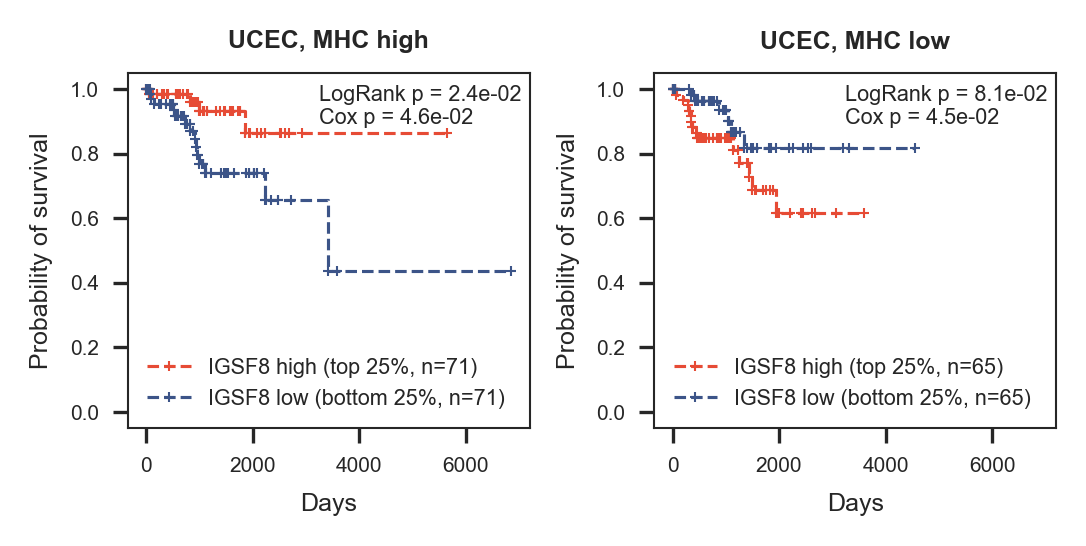

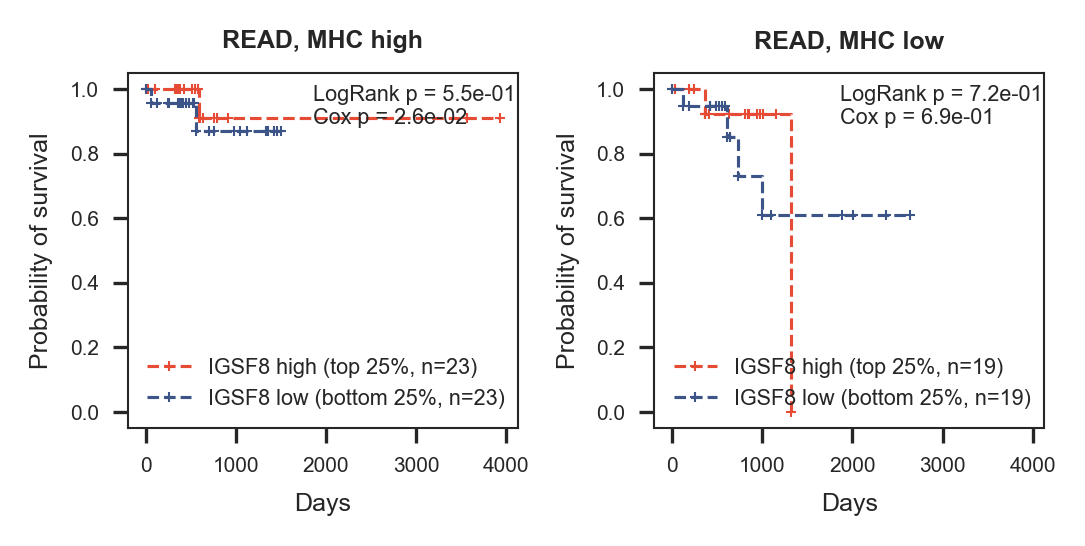

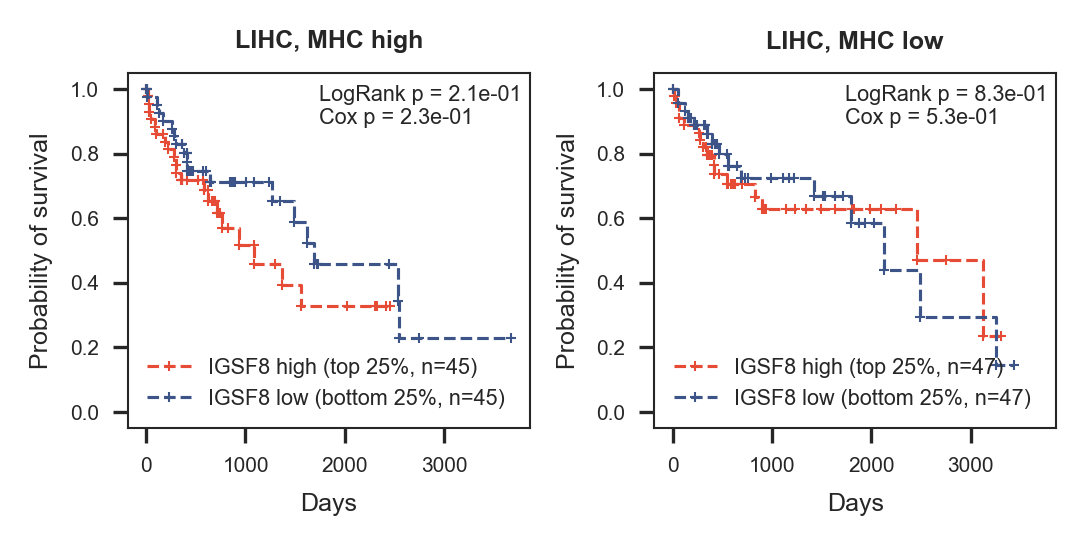

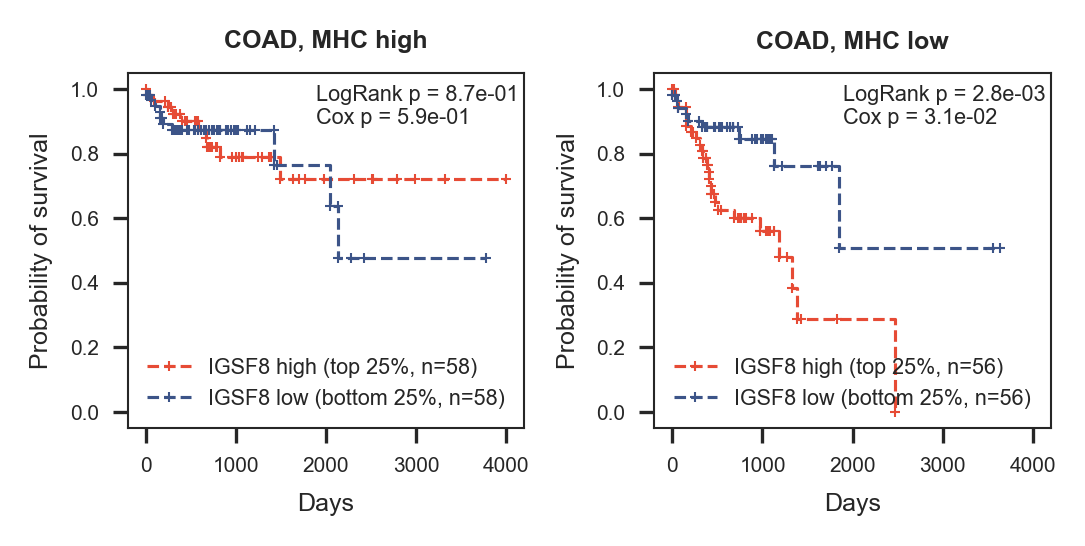

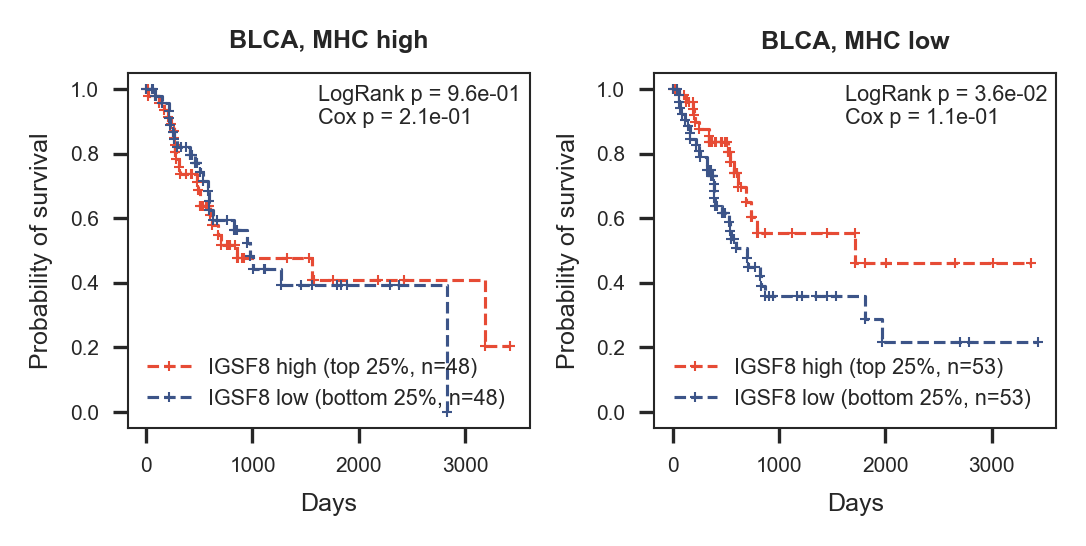

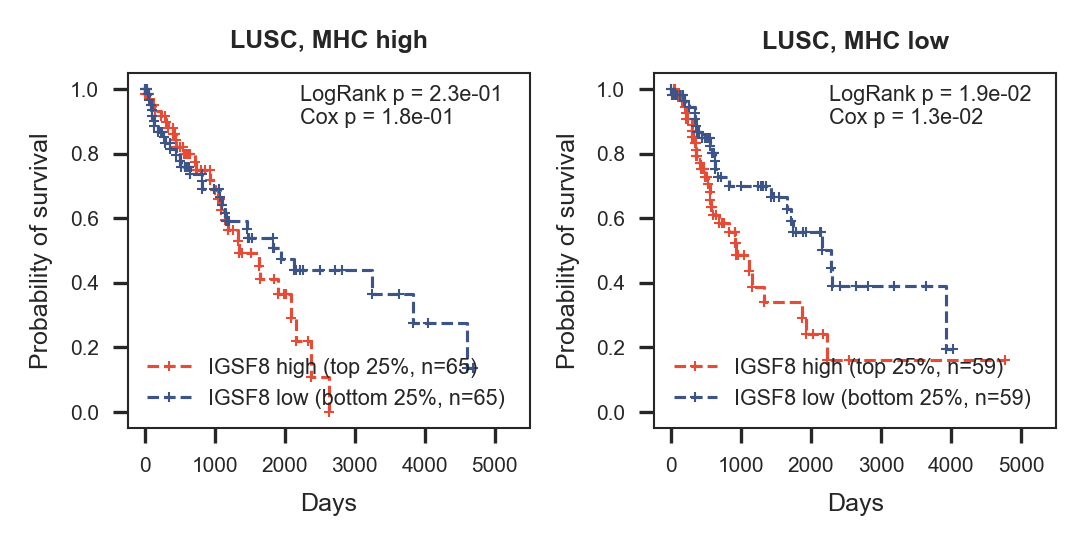

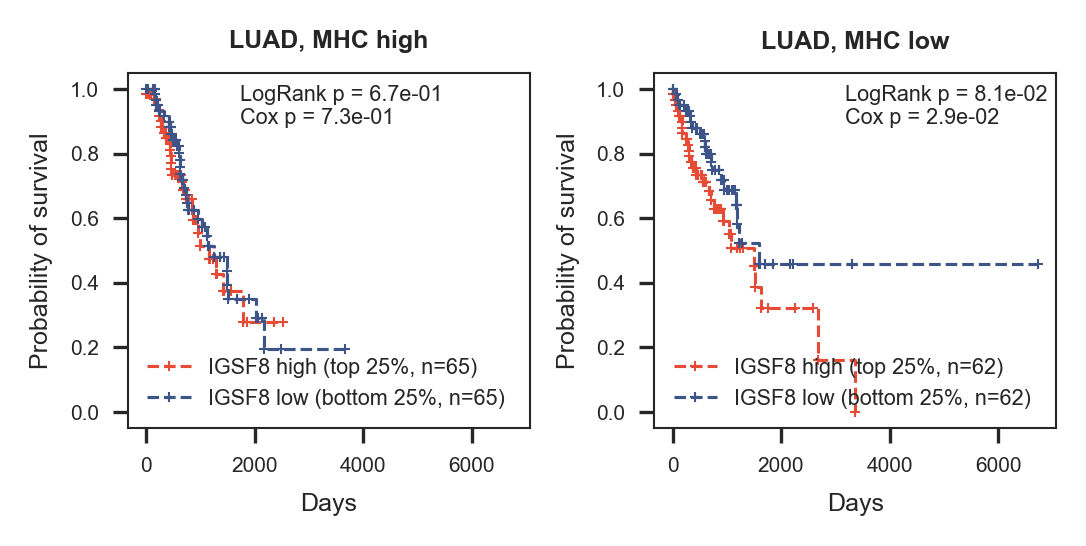

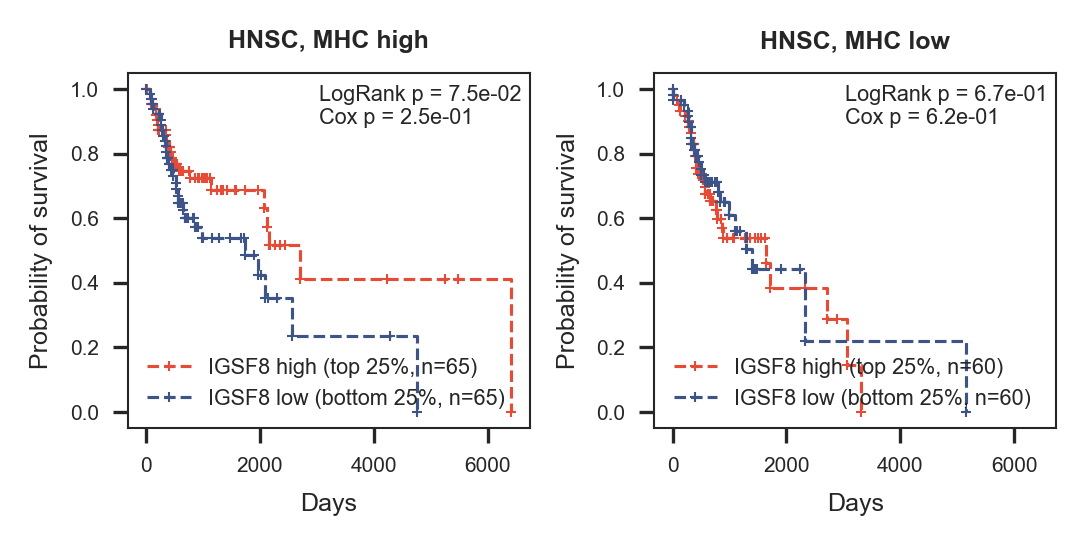

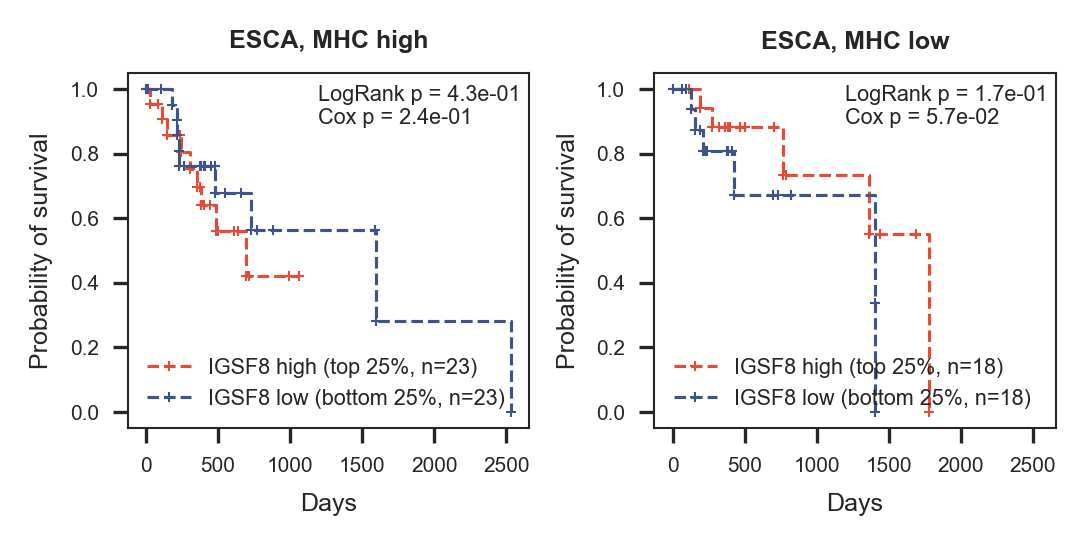

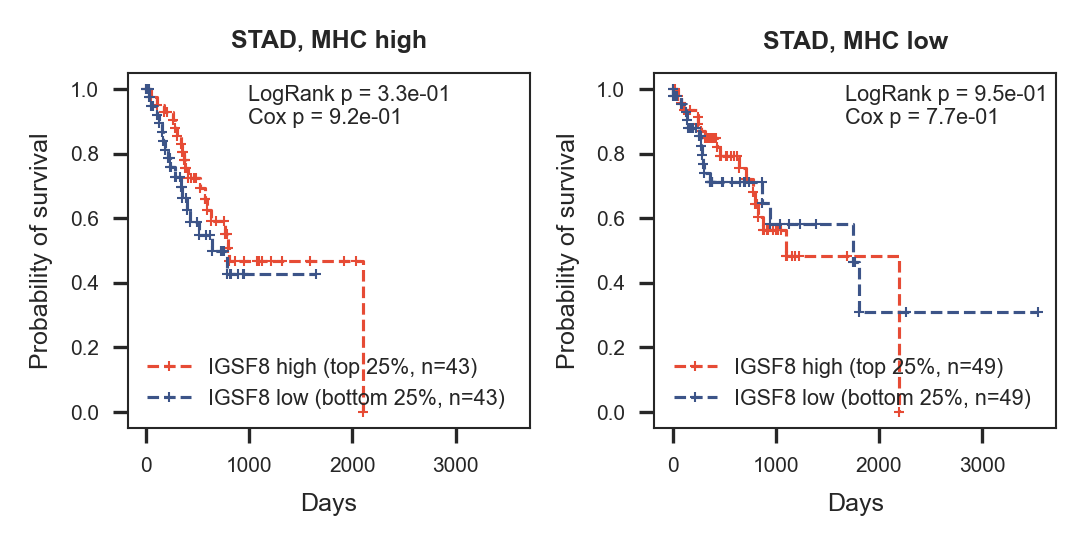

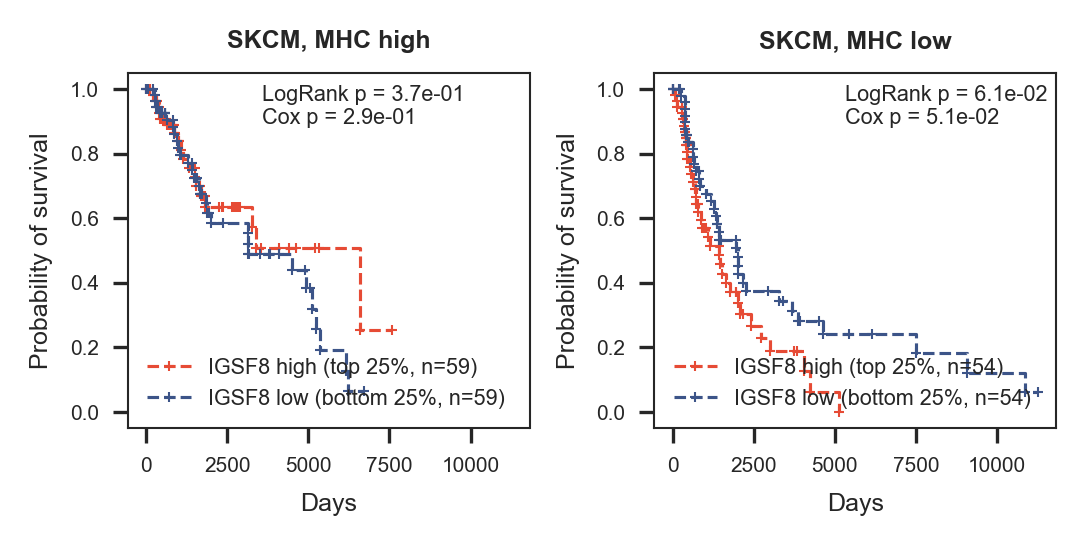

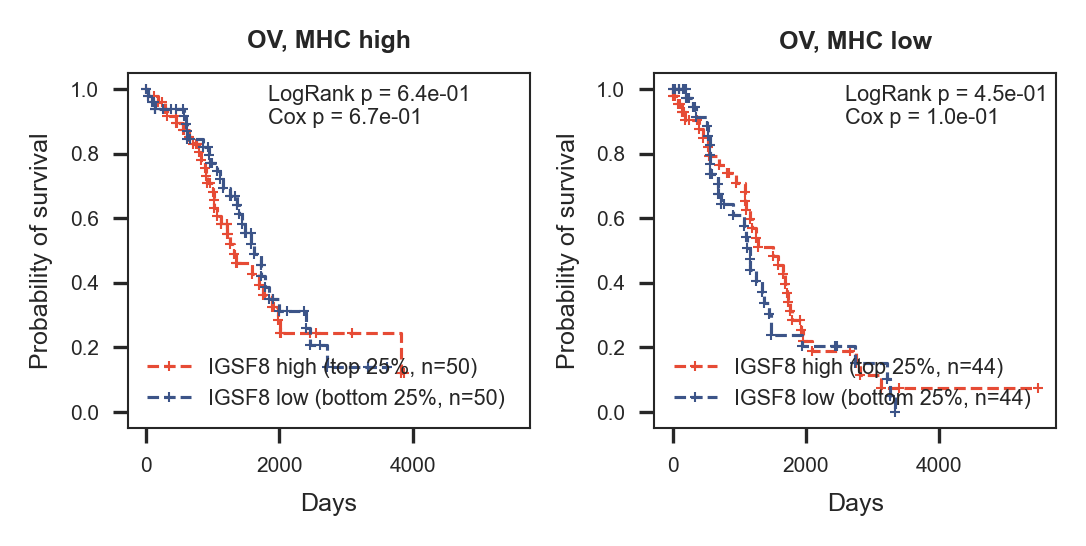

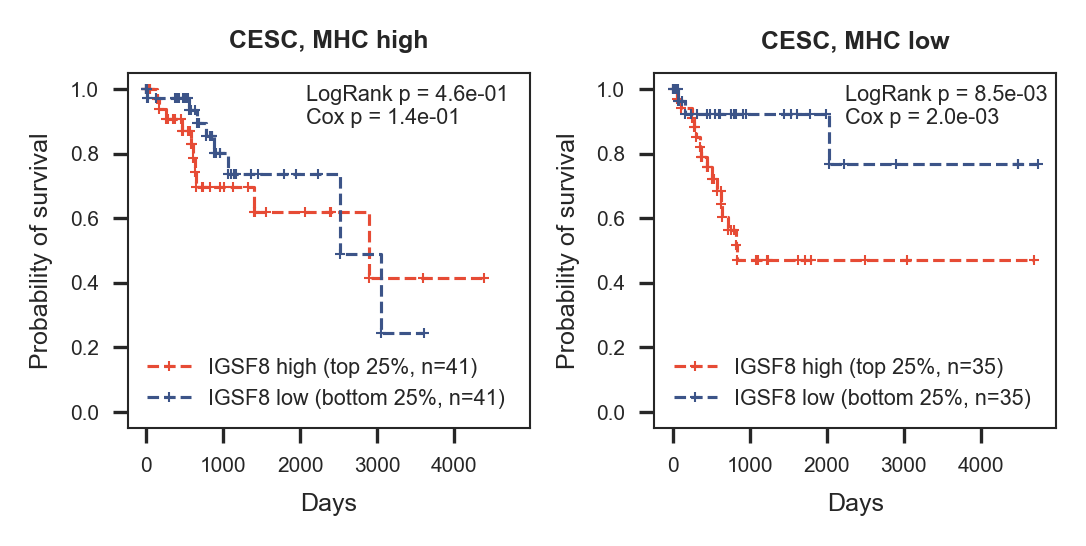

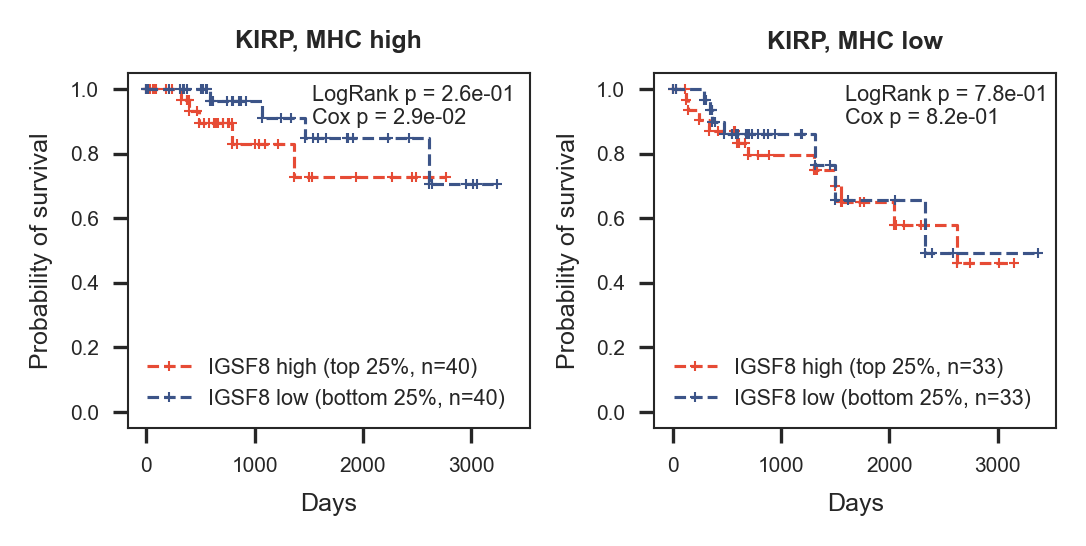

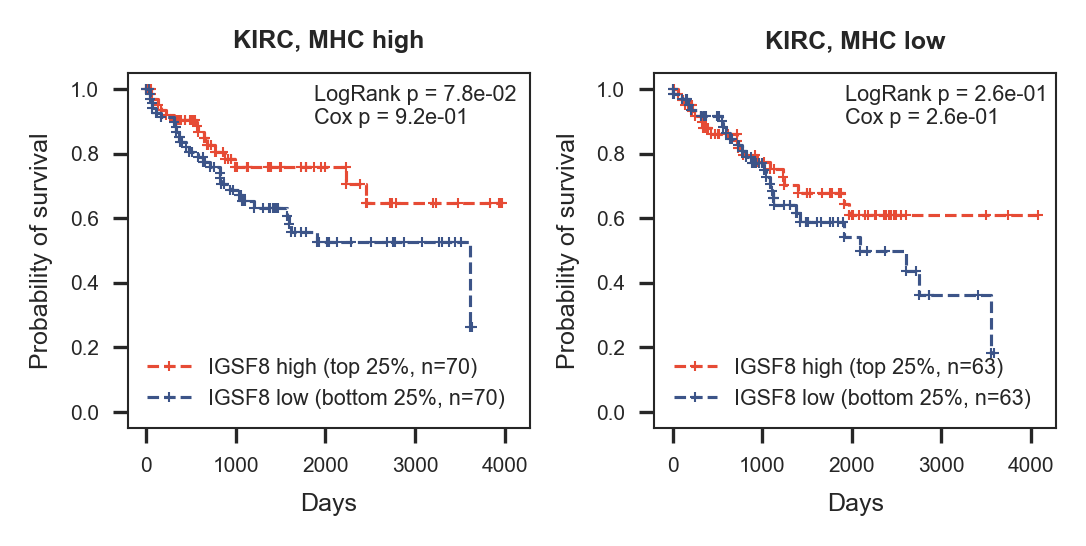

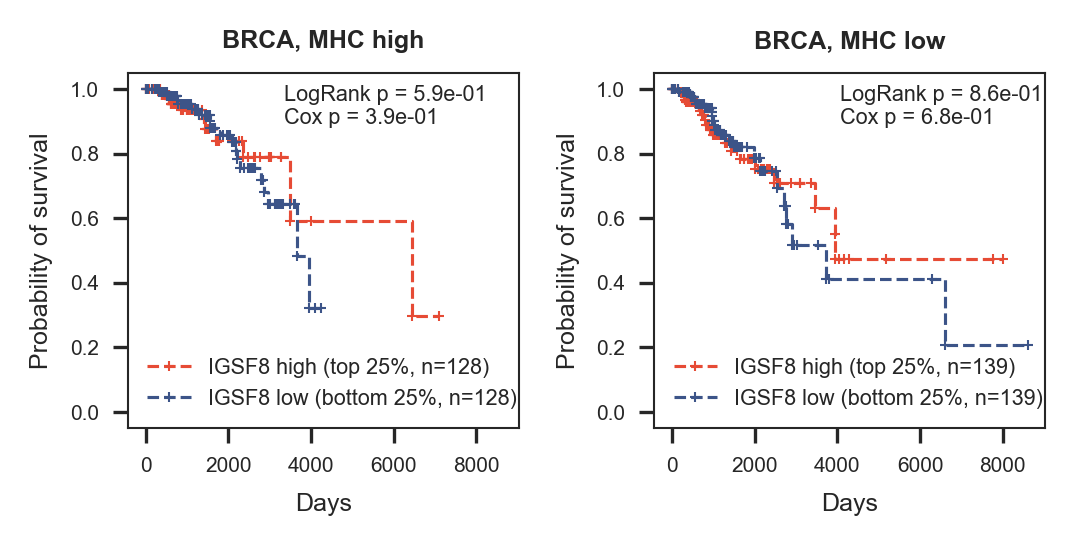

In [12]:
for pid in ['UCEC', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'OV', 
       'CESC', 'KIRP', 'KIRC', 'BRCA']:
    
    # get subset of the data
    survival_subdata = expr_data.query('project_id==@pid')
    
    # get for subgroups
    M_h_I_h, M_h_I_low, M_l_I_h, M_l_I_low = get_four_subpopulations(survival_subdata, divideby=["MHCI", "IGSF8"], cutoff=["mean", ".75"])
    
    # hypothesis testing for IGSF8-high and IGSF8-low groups within the MHCI-high population
    p_logrank1 = logrank_p_value(M_h_I_h, M_h_I_low, event="OS", time="OS.time")
    p_cox1, _ = cox_regression_p_value(pd.concat([M_h_I_h, M_h_I_low]), event="OS", time="OS.time")
    
    # hypothesis testing for IGSF8-high and IGSF8-low groups within the MHCI-low population
    p_logrank2 = logrank_p_value(M_l_I_h, M_l_I_low, event="OS", time="OS.time")
    p_cox2, _ = cox_regression_p_value(pd.concat([M_l_I_h, M_l_I_low]), event="OS", time="OS.time")
    
    # plotting
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(3.6, 1.8), sharex=True, sharey=False)
    
    survival_plot(M_h_I_h, ax=axes[0], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_h_I_h.shape[0]})')
    survival_plot(M_h_I_low, ax=axes[0], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_h_I_low.shape[0]})')
    axes[0].set(ylabel="Probability of survival", xlabel="Days", ylim=(-0.05,1.05), title=f"{pid}, MHC high")
    axes[0].title.set(weight="bold")
    axes[0].legend(frameon=False, loc='lower left', fontsize=5.2)#.get_texts()[0].set_fontstyle('oblique')
    xlim0 = axes[0].get_xlim()
    axes[0].text(xlim0[1] * .45, .82, f"LogRank p = {p_logrank1:.1e}\nCox p = {p_cox1:.1e}\n", fontsize=5.2) #, style='italic'

    survival_plot(M_l_I_h, ax=axes[1], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_l_I_h.shape[0]})')
    survival_plot(M_l_I_low, ax=axes[1], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_l_I_low.shape[0]})')
    axes[1].set(ylabel="Probability of survival", xlabel="Days", title=f"{pid}, MHC low", ylim=(-0.05,1.05))
    axes[1].title.set(weight="bold")
    axes[1].legend(frameon=False, loc='lower left', fontsize=5.2)
    xlim1 = axes[0].get_xlim()
    axes[1].text(xlim1[1] * .45, .82, f"LogRank p = {p_logrank2:.1e}\nCox p = {p_cox2:.1e}\n", fontsize=5.2) #, style='italic'

    # axes[1].text(0, .0, f"LogRank p = {p_logrank2:.1e}\nCox p = {p_cox2:.1e}\n", fontsize=4, style='italic')    
    
    xmin, xmax = axes[0].get_xlim()
    if pid =="LUSC": axes[0].set(xlim=(xmin, 5500))
    
    plt.savefig(f"../figures/survival_analysis_{pid}_IGSF8.pdf", bbox_inches = "tight")

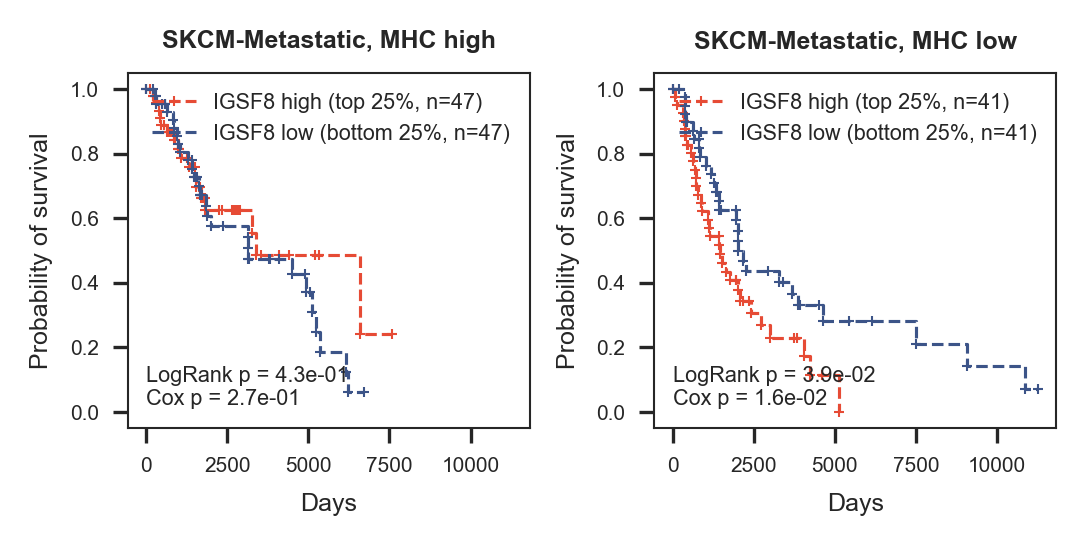

In [13]:
# Isolate and plot SKCM-Metastatic
for pid in ['SKCM']:
    survival_subdata = expr_data.query('project_id==@pid')
    survival_subdata = survival_subdata[survival_subdata["subtype(SKCM)"]=="SKCM-Metastatic"]

    M_h_I_h, M_h_I_low, M_l_I_h, M_l_I_low = get_four_subpopulations(survival_subdata, divideby=["MHCI", "IGSF8"], cutoff=["mean", ".75"])
    p_logrank1 = logrank_p_value(M_h_I_h, M_h_I_low, event="OS", time="OS.time")
    p_cox1, _ = cox_regression_p_value(pd.concat([M_h_I_h, M_h_I_low]), event="OS", time="OS.time")
    p_logrank2 = logrank_p_value(M_l_I_h, M_l_I_low, event="OS", time="OS.time")
    p_cox2, _ = cox_regression_p_value(pd.concat([M_l_I_h, M_l_I_low]), event="OS", time="OS.time")

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(3.6, 1.8), sharex=True, sharey=False)
    survival_plot(M_h_I_h, ax=axes[0], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_h_I_h.shape[0]})')
    survival_plot(M_h_I_low, ax=axes[0], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_h_I_low.shape[0]})')
    axes[0].set(ylabel="Probability of survival", xlabel="Days", title=f"{pid}-Metastatic, MHC high", ylim=(-0.05,1.05))
    axes[0].title.set(weight="bold")
    axes[0].legend(frameon=False, loc='upper right', fontsize=5.2)#.get_texts()[0].set_fontstyle('oblique')
    xlim0 = axes[0].get_xlim()
    axes[0].text(xlim0[1] * .0, -.05, f"LogRank p = {p_logrank1:.1e}\nCox p = {p_cox1:.1e}\n", fontsize=5.2) #, style='italic'

    survival_plot(M_l_I_h, ax=axes[1], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_l_I_h.shape[0]})')
    survival_plot(M_l_I_low, ax=axes[1], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_l_I_low.shape[0]})')
    axes[1].set(ylabel="Probability of survival", xlabel="Days", title=f"{pid}-Metastatic, MHC low", ylim=(-0.05,1.05))
    axes[1].title.set(weight="bold")
    axes[1].legend(frameon=False, loc='upper right', fontsize=5.2)
    xlim1 = axes[0].get_xlim()
    axes[1].text(xlim1[1] * .0, -.05, f"LogRank p = {p_logrank2:.1e}\nCox p = {p_cox2:.1e}\n", fontsize=5.2) #, style='italic'

    plt.savefig(f"../figures/survival_analysis_{pid}-Metastatic_IGSF8.pdf", bbox_inches = "tight")

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column stage have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'stage'].var())
>>> print(df.loc[~events, 'stage'].var())

A very low variance means that the column stage completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.246. This may imply non-unique solutions to the maximum likelihood. Perhaps there

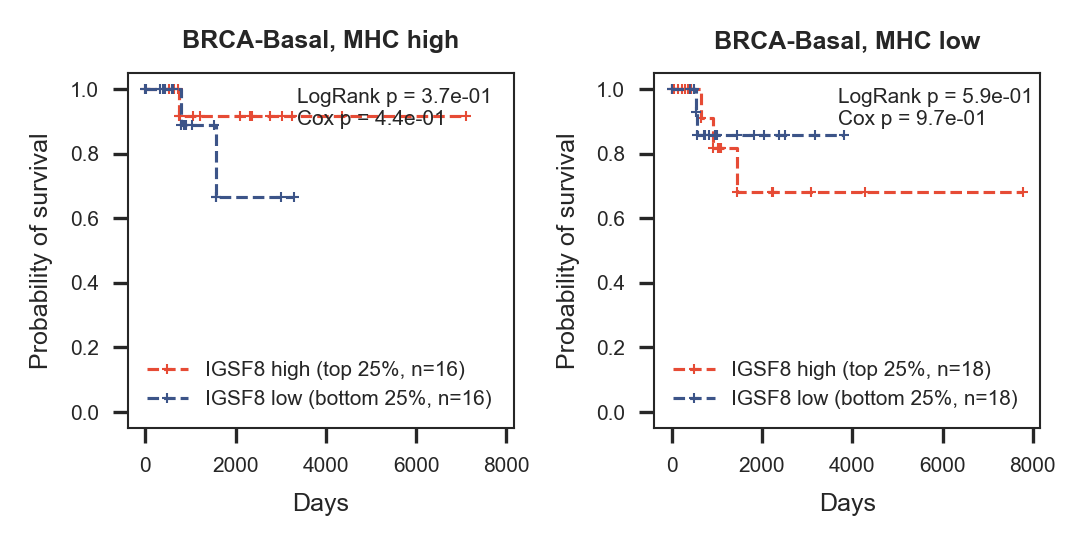

In [14]:
# Isolate and plot TNBC

for pid in ['BRCA']:
    survival_subdata = expr_data.query('project_id==@pid')
    survival_subdata = survival_subdata[survival_subdata["subtype(BRCA)"]=="Basal"]
    M_h_I_h, M_h_I_low, M_l_I_h, M_l_I_low = get_four_subpopulations(survival_subdata, divideby=["MHCI", "IGSF8"], cutoff=["mean", ".75"])
    p_logrank1 = logrank_p_value(M_h_I_h, M_h_I_low, event="OS", time="OS.time")
    p_cox1, _ = cox_regression_p_value(pd.concat([M_h_I_h, M_h_I_low]), event="OS", time="OS.time")
    p_logrank2 = logrank_p_value(M_l_I_h, M_l_I_low, event="OS", time="OS.time")
    p_cox2, _ = cox_regression_p_value(pd.concat([M_l_I_h, M_l_I_low]), event="OS", time="OS.time")

    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(3.6, 1.8), sharex=True, sharey=False)
    survival_plot(M_h_I_h, ax=axes[0], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_h_I_h.shape[0]})')
    survival_plot(M_h_I_low, ax=axes[0], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_h_I_low.shape[0]})')
    axes[0].set(ylabel="Probability of survival", xlabel="Days", title=f"{pid}-Basal, MHC high", ylim=(-0.05,1.05))
    axes[0].title.set(weight="bold")
    axes[0].legend(frameon=False, loc='lower left', fontsize=5)#.get_texts()[0].set_fontstyle('oblique')
    xlim0 = axes[0].get_xlim()
    axes[0].text(xlim0[1] * .45, .82, f"LogRank p = {p_logrank1:.1e}\nCox p = {p_cox1:.1e}\n", fontsize=5) #, style='italic'

    survival_plot(M_l_I_h, ax=axes[1], c=cmap.npg_palette(0),label=f'IGSF8 high (top 25%, n={M_l_I_h.shape[0]})')
    survival_plot(M_l_I_low, ax=axes[1], c=cmap.npg_palette(3), label=f'IGSF8 low (bottom 25%, n={M_l_I_low.shape[0]})')
    axes[1].set(ylabel="Probability of survival", xlabel="Days", title=f"{pid}-Basal, MHC low", ylim=(-0.05,1.05))
    axes[1].title.set(weight="bold")
    axes[1].legend(frameon=False, loc='lower left', fontsize=5)
    xlim1 = axes[0].get_xlim()
    axes[1].text(xlim1[1] * .45, .82, f"LogRank p = {p_logrank2:.1e}\nCox p = {p_cox2:.1e}\n", fontsize=5) #, style='italic'

    plt.savefig(f"survival_analysis_{pid}-Basal_IGSF8.pdf", bbox_inches = "tight")

In [15]:
# Calculate HR for all cohorts. Similar to the previous codes, but plotting is excluded.

coxs = []

for pid in ['UCEC', 'READ', 'LIHC', 'COAD', 'BLCA', 'LUSC',
       'LUAD', 'HNSC', 'ESCA', 'STAD', 'SKCM', 'OV', 
        'CESC', 'KIRP', 'KIRC', 'BRCA', 'PAAD',]:
        
    survival_subdata = expr_data.query('project_id==@pid')
    
    if pid == "SKCM":
        survival_subdata = survival_subdata.query('`subtype(SKCM)`=="SKCM-Metastatic"')
        pid = "SKCM-Metastatic"
        
    M_h_I_h, M_h_I_low, M_l_I_h, M_l_I_low = get_four_subpopulations(survival_subdata, divideby=["MHCI", "IGSF8"], cutoff=["mean", ".75"])

    p_logrank1 = logrank_p_value(M_h_I_h, M_h_I_low, event="OS", time="OS.time")
    p_cox1, cox1 = cox_regression_p_value(pd.concat([M_h_I_h, M_h_I_low]), event="OS", time="OS.time")
    cox1 = cox1.summary.loc['IGSF8', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].to_frame("MHC high").T

    p_logrank2 = logrank_p_value(M_l_I_h, M_l_I_low, event="OS", time="OS.time")
    p_cox2, cox2 = cox_regression_p_value(pd.concat([M_l_I_h, M_l_I_low]), event="OS", time="OS.time")
    cox2 = cox2.summary.loc['IGSF8', ['exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']].to_frame("MHC low").T
    cox = pd.concat([cox1, cox2], axis=0)
    cox['project'] = pid

    coxs.append(cox)
    
coxs = pd.concat(coxs)

/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/utils/__init__.py:1122: ConvergenceWarning: Column gender[T.MALE] have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['OS'].astype(bool)
>>> print(df.loc[events, 'gender[T.MALE]'].var())
>>> print(df.loc[~events, 'gender[T.MALE]'].var())

A very low variance means that the column gender[T.MALE] completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/Users/caibin/miniconda3/envs/general/lib/python3.10/site-packages/lifelines/fitters/coxph_fitter.py:1604: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.479. This may imply non-unique solutions to t

In [16]:
# target the cohorts of significance

coxs_mask = coxs.query('p<0.05')
coxs = coxs[coxs["project"].isin(coxs_mask['project'])]
coxs = coxs[~coxs["project"].isin(["HNSC", "READ", "KIRP"])]
coxs = coxs.rename_axis("MHC").reset_index()
coxs['ci'] = (coxs['exp(coef) upper 95%'] - coxs['exp(coef) lower 95%']) / 2

# manipulate the dataframe
coxs1 = coxs.set_index(["project", "MHC"]).unstack()
coxs1.columns = coxs1.columns.swaplevel()
coxs1 = coxs1.sort_index(axis=1)

MHCI_low_HR = coxs1[['MHC low']].sort_values(("MHC low", "exp(coef)")).reset_index()
MHCI_high_HR = coxs1[['MHC high']].reindex(MHCI_low_HR['project']).reset_index()

In [17]:
# set markers for different groups, MHCI-high and MHCI-low

errorbar_kwargs_low = {"c": cmap.npg_palette(3),
                       "fmt": "s",
                       "markersize": 3,
                       "markerfacecolor": cmap.npg_palette(3),
                       "markeredgewidth": .5,
                       "capsize": 1.,
                       "elinewidth": .5
                      }

errorbar_kwargs_high = {"c": cmap.npg_palette(0),
                        "fmt": "s",
                        "markersize": 3,
                        "markerfacecolor": cmap.npg_palette(0),
                        "markeredgewidth": .5,
                        "capsize": 1.,
                        "elinewidth": .5
                       }

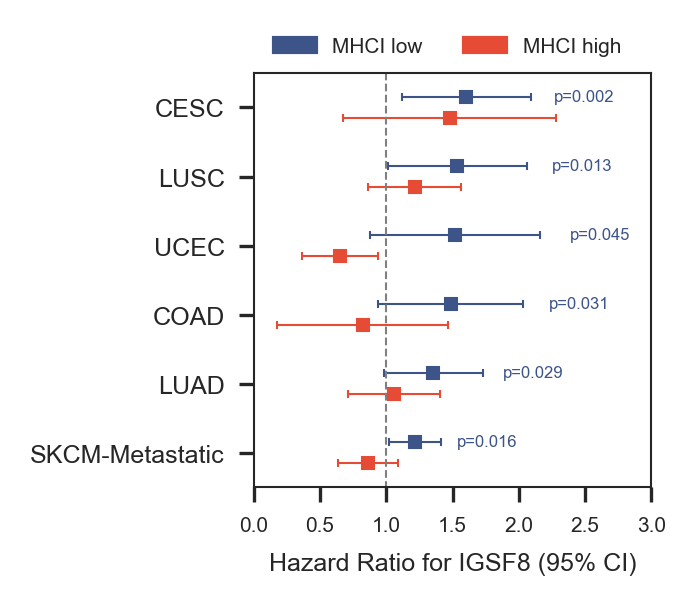

In [18]:
# plotting

plt.figure(figsize = (2.3, 2.));
plt.errorbar(MHCI_low_HR['MHC low']["exp(coef)"], MHCI_low_HR.index + .15, xerr=MHCI_low_HR['MHC low']["ci"], **errorbar_kwargs_low);
plt.errorbar(MHCI_high_HR['MHC high']["exp(coef)"], MHCI_high_HR.index - .15, xerr=MHCI_high_HR['MHC high']["ci"], **errorbar_kwargs_high);

[plt.text(row["exp(coef) upper 95%"] + .1, idx + .1, f"p={row['p']:.3f}", fontsize=4, c=cmap.npg_palette(3)) for idx, row in MHCI_low_HR['MHC low'].iterrows()]
# [plt.text(row["exp(coef) upper 95%"] + .1, idx - .2, f"p={row['p']:.3f}", fontsize=4, c=cmap.npg_palette(0)) for idx, row in MHCI_high_HR['MHC high'].iterrows() if row['p']<.05]

plt.vlines(1, -1., 6, ls="--", lw=.5, color='gray')
plt.yticks(MHCI_low_HR.index, MHCI_low_HR['project'].values, fontsize=6)
plt.ylim(-.5, 5.5)
plt.xlim(0, 3.)
plt.xlabel("Hazard Ratio for IGSF8 (95% CI)", fontsize=6)

handles = [
    Patch(edgecolor=color, facecolor=color, label=label) 
    for label, color in zip(['MHCI low', 'MHCI high'], [cmap.npg_palette(3), cmap.npg_palette(0)])
]
plt.legend(handles=handles, loc=(0.03, 1.02), ncols=2, fontsize=5, frameon=False);

plt.savefig("../figures/Fig3f.pdf")